In [1]:
from config import cfg
import os
import numpy as np
import pandas as pd
import mne
from util import read_emg, read_manus
from scipy.signal import butter, filtfilt, iirnotch, sosfiltfilt, stft


In [2]:
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler

class ExpTimes:
    refernce_time = datetime.strptime('2023-10-02 14:59:55.627000', '%Y-%m-%d %H:%M:%S.%f')
    manus_start_time = datetime.strptime('2023-10-02 14:59:20.799000', '%Y-%m-%d %H:%M:%S.%f')
    emg_start_time = datetime.strptime('2023-10-02 14:59:55.627000', '%Y-%m-%d %H:%M:%S.%f')
    video_Start_time = datetime.strptime('2023-10-02 14:59:55.628000', '%Y-%m-%d %H:%M:%S.%f')

    manus_columns = ['Pinch_ThumbToIndex','Pinch_ThumbToMiddle', 'Pinch_ThumbToRing',
                     'Pinch_ThumbToPinky', 'Thumb_CMC_Spread', 'Thumb_CMC_Flex', 'Thumb_PIP_Flex', 'Thumb_DIP_Flex',
                     'Index_MCP_Spread', 'Index_MCP_Flex', 'Index_PIP_Flex', 'Index_DIP_Flex', 'Middle_MCP_Spread',
                     'Middle_MCP_Flex', 'Middle_PIP_Flex', 'Middle_DIP_Flex', 'Ring_MCP_Spread', 'Ring_MCP_Flex',
                     'Ring_PIP_Flex', 'Ring_DIP_Flex', 'Pinky_MCP_Spread', 'Pinky_MCP_Flex', 'Pinky_PIP_Flex',
                     'Pinky_DIP_Flex','time']


In [3]:
# edf_path = os.path.join(cfg.DATA.PATH, 'test 2023-10-02 14-59-55-627.edf')
# manus_path = os.path.join(cfg.DATA.PATH, 'Untitled_2023-10-02_15-24-12_YH_lab_R.csv')

# #read data
# df = read_data([manus_path, edf_path])
# df.head()

In [93]:
# make a tesor dataset class
from torch.utils.data import Dataset
import torch
DATA_SOURCES = {
    'manus': read_manus,
    'emg': read_emg,
}
cfg.DATA.EMG.SAMPLING_RATE = 125
class EMGDataset(Dataset):
    def __init__(self, data_path, label_path, transform=None, data_source='emg', label_source='manus'):

        self.data_path = data_path
        self.label_path = label_path
        self.seq_len = 150
        self.transform = transform

        self.data_source = data_source # emg or imu
        self.label_source = label_source   # manus, video, or ultraleap 

        self.emg_columns = ['channel {}'.format(i) for i in range(16)]
        self.mauns_columns = ['Pinch_ThumbToIndex','Pinch_ThumbToMiddle', 'Pinch_ThumbToRing',
                        'Pinch_ThumbToPinky', 'Thumb_CMC_Spread', 'Thumb_CMC_Flex', 'Thumb_PIP_Flex', 'Thumb_DIP_Flex',
                        'Index_MCP_Spread', 'Index_MCP_Flex', 'Index_PIP_Flex', 'Index_DIP_Flex', 'Middle_MCP_Spread',
                        'Middle_MCP_Flex', 'Middle_PIP_Flex', 'Middle_DIP_Flex', 'Ring_MCP_Spread', 'Ring_MCP_Flex',
                        'Ring_PIP_Flex', 'Ring_DIP_Flex', 'Pinky_MCP_Spread', 'Pinky_MCP_Flex', 'Pinky_PIP_Flex',
                        'Pinky_DIP_Flex','time']
        
        self.prepare_data()
        self.discritize_data()

        print(f'shape of data: {self.data.shape}\nshape of label: {self.label.shape}')
        
    def prepare_data(self):
        data =  DATA_SOURCES[self.data_source](self.data_path)
        label = DATA_SOURCES[self.label_source](self.label_path)
        
        # set the start and end of experiment
        start_time = max(min(data.index), min(label.index))
        end_time = min(max(data.index), max(label.index))

        # select only the data between start and end time
        data = data.loc[start_time:end_time]
        label = label.loc[start_time:end_time]
        self.data_df = data.copy()
        self.label_df = label.copy()

        # # make sure the dataframes are of the same length for the merge
        # df = pd.merge_asof(data, label, on='time', direction='nearest')
        # print(df.describe())
        # assert df.shape[0] == data.shape[0] & df.shape[0] == label.shape[0], 'Dataframes are not of the same length'
        # del df

        #reset index to numeric values
        data.reset_index(drop=True, inplace=True)
        label.reset_index(drop=True, inplace=True)

        #convert to numpy array
        self.data = data.to_numpy()
        self.label = label.to_numpy()

        # normalize the data
        print(f'max before scaling: {np.max(self.data)}\nmin before scaling: {np.min(self.data)}')
        scaler = StandardScaler()
        self.data = scaler.fit_transform(self.data)
        print(f'max: {np.max(self.data)}\nmin: {np.min(self.data)}')
        #filter data
        self.data = self._filter_data(self.data, fs=cfg.DATA.EMG.SAMPLING_RATE, 
                                      notch=cfg.DATA.EMG.NOTCH, low_freq=cfg.DATA.EMG.LOW_FREQ, 
                                      high_freq=cfg.DATA.EMG.HIGH_FREQ, buff_len=cfg.DATA.EMG.BUFF_LEN)

        print(f'max after filtering: {np.max(self.data)}\nmin after filtering: {np.min(self.data)}')
        #discritize
        # self.data = self.unfold(self.data, cfg.DATA.SEGMENT_LENGTH)
        # self.label = self.unfold(self.label, cfg.DATA.SEGMENT_LENGTH)

        # convert to tensor
        self.data = torch.tensor(self.data.copy())
        self.label = torch.tensor(self.label.copy())


    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.label[idx]
        return data, label
    
    #discritize the data into sequences of length seq_len using torch
    def discritize_data(self):
        self.data = self.data.unfold(0, self.seq_len, 1).permute(0, 2, 1).unsqueeze(1)
        self.label = self.label.unfold(0, self.seq_len, 1).permute(0, 2, 1).unsqueeze(1)

    @staticmethod
    def _filter_data(data: np.ndarray, fs: float, notch: float=50, low_freq: float=30.0, high_freq: float=250.0,
                     buff_len: int = 0) -> np.ndarray:
        # Define the notch frequency and quality factor
        notch_freq = 50  # Hz
        Q = 30

        # Calculate the normalized frequency and design the filter
        w0 = notch_freq / (fs / 2)
        b_notch, a_notch = iirnotch(w0, Q)

        cutoff = low_freq / (fs / 2)
        sos = butter(5, cutoff, btype='highpass', output='sos')

        # apply filters using 'filtfilt' to avoid phase shift
        data = sosfiltfilt(sos, data, axis=0, padtype='even')

        # Apply the filter to your signal using filtfilt to avoid phase shift
        filtered_signal = filtfilt(b_notch, a_notch, data, axis=0)
        
        return filtered_signal
    
    @staticmethod
    def unfold(data, seq_len):
        '''
        Unfold the data into segments of length seq_len
        Input: data: numpy array of shape (num_samples, num_features)
                seq_len: length of each segment
        Output: segments: numpy array of shape (num_segments, seq_len, num_features)
        '''
        original_length, num_features = data.shape
        num_segments = (original_length - seq_len + 1) * seq_len

        # Reshape the data to (num_segments, seq_len, num_features)
        segments = np.lib.stride_tricks.sliding_window_view(data, (seq_len, num_features))
        segments = segments.squeeze(1)
        return segments
    
    @staticmethod
    def fold(data):
        '''
        Fold the data into a single array
        Input: segments: numpy array of shape (num_segments, seq_len, num_features)
        Output: segments: numpy array of shape (num_samples, num_features)
        '''
        num_segments, seq_len, num_features = data.shape
        original_length = int(num_segments) + seq_len - 1

        # Reshape the data to (num_segments, seq_len, num_features)
        segments = np.lib.stride_tricks.as_strided(data, shape=(original_length, num_features), strides=(1,1))
        return segments

        

In [94]:
cfg.DATA.PATH = './dataset'
manus_path = os.path.join(cfg.DATA.PATH, 'label_2023-10-02_15-24-12_YH_lab_R.csv')
edf_path = os.path.join(cfg.DATA.PATH, 'data_2023-10-02 14-59-55-627.edf')
dataset = EMGDataset(edf_path, manus_path)

Extracting EDF parameters from /Users/rufaelmarew/Documents/tau/finger_pose_estimation/dataset/data_2023-10-02 14-59-55-627.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345249  =      0.000 ...  1380.996 secs...
max before scaling: 7606.120889004178
min before scaling: -12500.721537827692
max: 39.82525699968052
min: -40.870744738463785
max after filtering: 22.361682666780784
min after filtering: -21.109814151344402
shape of data: torch.Size([164501, 1, 150, 16])
shape of label: torch.Size([164501, 1, 150, 15])


In [95]:
print(dataset.data.shape)

torch.Size([164501, 1, 150, 16])


In [96]:
# dataset.fold(dataset.data).shape

In [97]:
torch.max(dataset.data.squeeze(1)[:,0,:], axis=0)[0]

tensor([ 8.7271, 17.4881,  9.4010,  9.6708,  4.2985,  6.6092, 16.2338,  9.2201,
         9.0151, 10.4400, 22.3617,  7.3145,  5.1731,  9.4766,  6.5102, 10.7852],
       dtype=torch.float64)

(164501, 16)


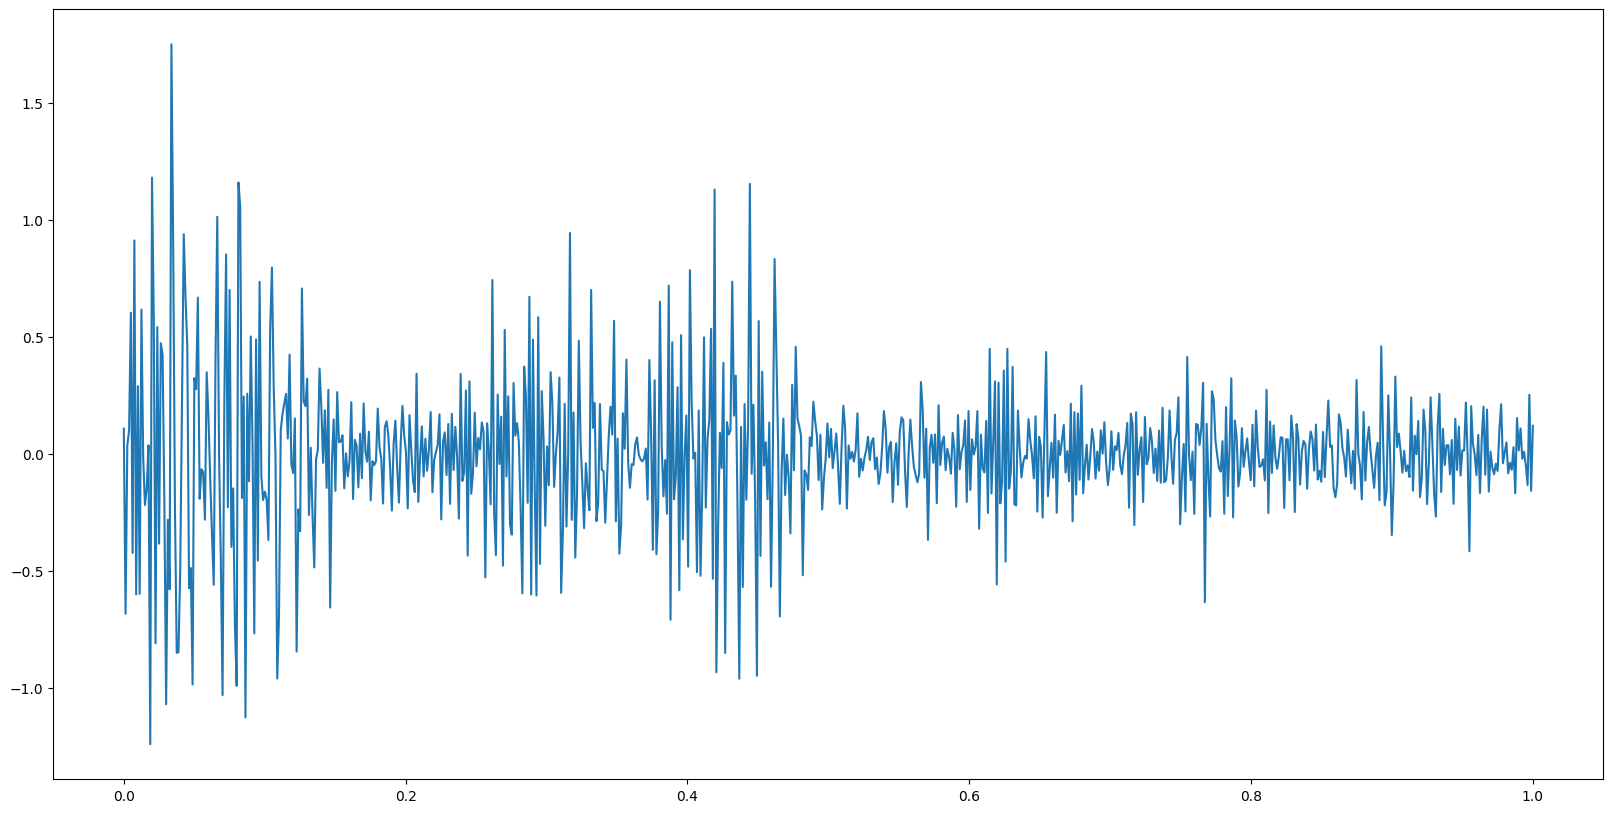

In [99]:
def plot_data(to_plot):
    import matplotlib.pyplot as plt
    # fold the data
    print(to_plot.shape)
    t = np.linspace(0, 1, to_plot[:800,:].shape[0])
    # set figure size
    plt.figure(figsize=(20,10))
    plt.plot(t, to_plot[:800,5])
    plt.show()
plot_data(dataset.data.squeeze(1)[:,0,:].numpy())

In [92]:
dataset.data_df.head()

,Channel 0,Channel 1,Channel 2,Channel 3,Channel 4,Channel 5,Channel 6,Channel 7,Channel 8,Channel 9,Channel 10,Channel 11,Channel 12,Channel 13,Channel 14,Channel 15
time,,,,,,,,,,,,,,,,
2023-10-02 14:59:55.631,25.733771,3.077092,22.661679,1.541046,102.536072,28.037840,25.733771,196.234879,122.504670,-33.019989,187.018603,-68.733059,-2.299069,-36.476093,7.685230,-29.179874
2023-10-02 14:59:55.639,-5.755173,-18.811564,-4.987150,-17.275518,79.495382,-2.683081,33.414001,254.604628,122.888682,-25.723771,196.234879,-104.830141,-23.803713,-31.867955,49.158473,-28.411851
2023-10-02 14:59:55.647,-17.659529,42.246266,19.589587,-16.123483,87.559623,24.965748,51.846553,283.021480,142.473269,-43.004289,202.379063,-100.990026,-12.283368,-51.836553,140.553211,-36.476093
2023-10-02 14:59:55.655,-4.603138,98.311945,21.509644,-21.115633,86.023577,31.877955,47.622427,285.325549,105.608164,-44.156323,192.010753,-86.397589,1.157035,-59.900795,169.354074,-45.692369
2023-10-02 14:59:55.663,-8.443253,56.838703,42.246266,-10.747322,102.152060,49.542484,62.982887,298.765951,120.200601,1.541046,186.250580,-48.380450,28.805863,-25.723771,-135.935073,-10.747322
